In [48]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load Dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\Titanic-Dataset.csv")
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
# Check for NULL data
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# Data Cleaning
df = df.drop(["PassengerId", "Ticket", "Cabin","Name"], axis=1)

In [11]:
# Handle Missing Values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])


In [12]:
# OneHot Encoding
df = pd.get_dummies(df,columns=["Embarked"],drop_first=True)

In [15]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

In [16]:
# Define Features and Target
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [33]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Handle Class Imbalance using SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)


In [35]:
# Cross-Validation setup
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [36]:
# Model 1:- XGBoost
xgb = XGBClassifier(random_state=42,eval_metric="logloss",use_label_encoder=False)
param_grid = {
    "n_estimators":[100,150,200],
    "max_depth":[3,4,5],
    "learning_rate":[0.1,0.01,0.5,0.05],
    "colsample_bytree":[0.6,0.7,0.8,0.9],
    "subsample":[0.6,0.7,0.8,0.9],
    "gamma":[0.6,0.7,0.8,0.9],
    "reg_lambda":[1,2,3],
    "reg_alpha":[0.8,1]
}
grid_xgb = RandomizedSearchCV(xgb,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc",
n_iter=20,random_state=42)
grid_xgb.fit(x_res,y_res)
print(grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_

0.9042952565676968


In [37]:
# Model 2:- Catboost
cat = CatBoostClassifier(eval_metric="AUC",random_seed=42,verbose=100)
param_grid = {
    "iterations":[100,500,800],
    "learning_rate":[0.1,0.5,0.01,0.05],
    "depth":[4,5,6]
}
grid_cat = RandomizedSearchCV(cat,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc"
,n_iter=20,random_state=42)
grid_cat.fit(x_res,y_res)
print(grid_cat.best_score_)
best_cat = grid_cat.best_estimator_


0:	total: 2.9ms	remaining: 2.31s
100:	total: 188ms	remaining: 1.3s
200:	total: 368ms	remaining: 1.1s
300:	total: 535ms	remaining: 886ms
400:	total: 700ms	remaining: 696ms
500:	total: 861ms	remaining: 514ms
600:	total: 1.02s	remaining: 337ms
700:	total: 1.16s	remaining: 164ms
799:	total: 1.32s	remaining: 0us
0.9092092653590569


In [38]:
# Model 3:- Gradient Boosting
gd = GradientBoostingClassifier(random_state=42)
param_grid = {
    "max_depth":[2,3,4,5],
    "learning_rate":[0.1,0.01,0.5,0.05],
    "n_estimators":[100,150,200]
}
grid_gd = RandomizedSearchCV(gd,param_grid,cv=sk,n_jobs=-1,n_iter=20,scoring="roc_auc",random_state=42)
grid_gd.fit(x_res,y_res)
print(grid_gd.best_score_)
best_gd = grid_gd.best_estimator_

0.9029482905051015


In [39]:
# Meta Model - Logistic Regression
lr = LogisticRegression(random_state=42,class_weight="balanced")
param_grid = {
    "max_iter":[500,1000],
    "C":[0.1,0.4]
}
grid_lr = RandomizedSearchCV(lr,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc",
n_iter=20,random_state=42)
grid_lr.fit(x_train,y_train)
best_lr = grid_lr.best_estimator_

In [40]:
# Build Staking Ensemble
base_models = [
    ("cat", best_cat),
    ("gd", best_gd),
    ("xgb", best_xgb)
]
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=best_lr,
    passthrough=True,
    cv=5,
    n_jobs=-1
)
stack.fit(x_res, y_res)

StackingClassifier(cv=5,
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001BA12DB7D70>),
                               ('gd',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=4,
                                                           n_estimators=150,
                                                           random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, device=None,
                                              ear...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(C=0.4,
                                                      class_weight='balanced',
                                                      max_iter=500,
                                                      random_state=42),
                   n_jobs=-1, passthrough=True)

In [41]:
# Evalutaion
y_pred = stack.predict(x_test)
y_proba = stack.predict_proba(x_test)[:, 1]

print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Train Accuracy:", accuracy_score(y_train, stack.predict(x_train)))
print("✅ ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

✅ Test Accuracy: 0.8547486033519553
✅ Train Accuracy: 0.9115168539325843
✅ ROC AUC: 0.8840411840411839

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       105
           1       0.82      0.82      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)



Confusion Matrix:
 [[92 13]
 [13 61]]


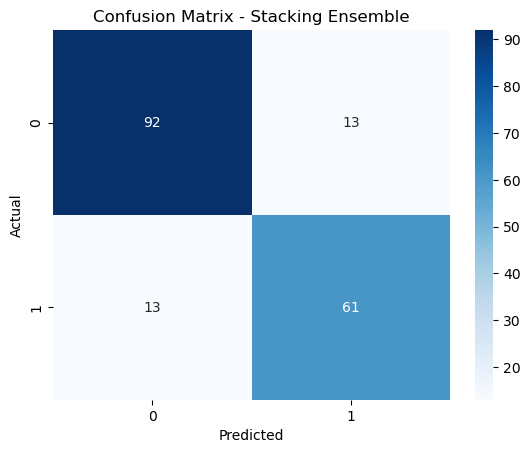

In [51]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Ensemble")
plt.show()


In [44]:
# Cross Validation score
cv_score = cross_val_score(stack, X, y, cv=sk, n_jobs=-1)
print("\nCross Validation Mean Score:", cv_score.mean())


Cross Validation Mean Score: 0.8305191136777352


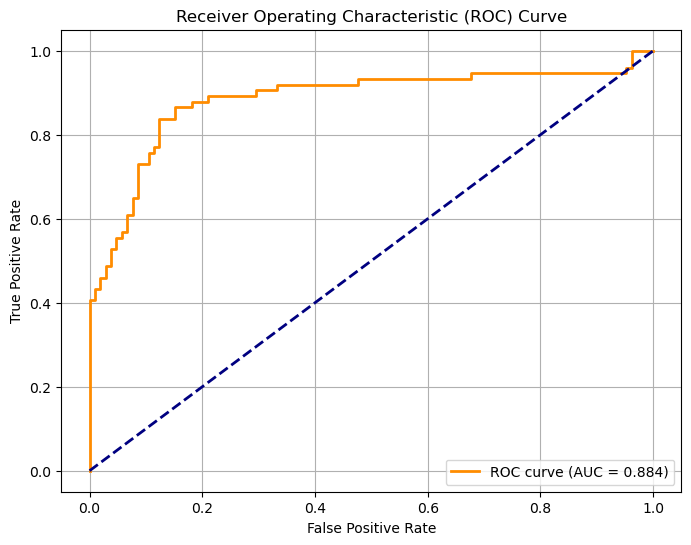

In [49]:
#✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()